In [3]:
import pandas as pd
import numpy as np
from collections import defaultdict
from operator import itemgetter
from IPython.display import display, IFrame

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.utils import shuffle

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [37]:
# helpful functions

def showAll(status=True):
    if status:
        pd.set_option("display.max_rows", None)
    else:
        pd.set_option("display.max_rows", 10)

def sortListofTuples(tuples, reverse=False):
    return sorted(tuples, key=itemgetter(1), reverse=reverse)

def standardize(data, ddof=0):
    return (data - np.mean(data)) / np.std(data, ddof=ddof)

In [38]:
# Import dataset

df = pd.read_csv('C:/Users/phuro/UCSD/ULI/H2H/ULI-UCSD_H2H/LIHTC_analysis/data/stratified_lihtc.csv', index_col=0)
df.head()

,inc_ceil,low_ceil,non_prof,basis,bond,mff_ra,fmha_515,fmha_538,home,cdbg,hopevi,tcep,rentassist,trgt_pop,trgt_fam,trgt_eld,trgt_dis,trgt_hml,trgt_other,type,credit,metro,dda,qct,is_highMOE,target
29023,2.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0,2.0,0,636179.0
47271,2.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,0,333463.0
47296,2.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,2.0,1,562375.0
12677,2.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0,385630.0
47256,2.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,0.0,2.0,0,806735.0


In [39]:
df.drop(columns=['is_highMOE'], inplace=True)

In [40]:
# GOALs:
# 
# stratify: have 2 models: 1 model with lower allocation amounts, and 1 with larger amounts
# following the histogram of allocamt, cut at 0.8 mil to separate two datasets

# try logistic reg

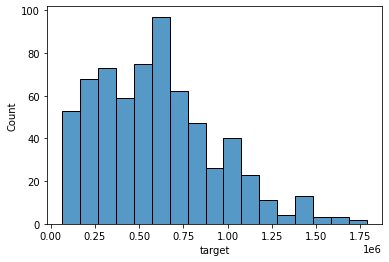

In [41]:
sns.histplot(df.target);

In [42]:
# split projects into low and high allocation amount at 0.8 million

dfLow = df[df.target < 800000]
dfHigh = df[df.target >= 800000]

dfLow['target'] = standardize(dfLow.target)
dfHigh['target'] = standardize(dfHigh.target)

print(dfLow.shape)
print(dfHigh.shape)

(498, 25)
(161, 25)


In [43]:
df.head(1)

,inc_ceil,low_ceil,non_prof,basis,bond,mff_ra,fmha_515,fmha_538,home,cdbg,hopevi,tcep,rentassist,trgt_pop,trgt_fam,trgt_eld,trgt_dis,trgt_hml,trgt_other,type,credit,metro,dda,qct,target
29023,2.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0,2.0,636179.0


In [44]:
# Model for projects with lower allocation amounts

formulaLow = 'target ~ ' + ' + '.join(dfLow.columns.difference(['target']))
print(formulaLow)
mdlLow = smf.ols(formulaLow, data=dfLow).fit()
print(mdlLow.summary())

target ~ basis + bond + cdbg + credit + dda + fmha_515 + fmha_538 + home + hopevi + inc_ceil + low_ceil + metro + mff_ra + non_prof + qct + rentassist + tcep + trgt_dis + trgt_eld + trgt_fam + trgt_hml + trgt_other + trgt_pop + type
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     5.239
Date:                Fri, 10 May 2024   Prob (F-statistic):           1.11e-13
Time:                        19:54:26   Log-Likelihood:                -647.94
No. Observations:                 498   AIC:                             1346.
Df Residuals:                     473   BIC:                             1451.
Df Model:                          24                                         
Covariance Type:            nonrobust                   

In [45]:
# get signicant variables (pval < 5%)

sigLow = mdlLow.pvalues[mdlLow.pvalues < 0.05].index.to_list()
sigLow

['basis', 'dda', 'fmha_515', 'mff_ra', 'qct', 'type']

In [47]:
# rank coefficients

mdlLow.params.sort_values(ascending=False)[:6]

Intercept     1.276181
mff_ra        0.923500
metro         0.256564
cdbg          0.229998
trgt_other    0.154961
trgt_dis      0.061070
dtype: float64

In [48]:
# Model for projects with higher allocation amounts

formulaHigh = 'target ~ ' + ' + '.join(dfHigh.columns.difference(['target']))
print(formulaHigh)
mdlHigh = smf.ols(formulaHigh, data=dfHigh).fit()
print(mdlHigh.summary())

target ~ basis + bond + cdbg + credit + dda + fmha_515 + fmha_538 + home + hopevi + inc_ceil + low_ceil + metro + mff_ra + non_prof + qct + rentassist + tcep + trgt_dis + trgt_eld + trgt_fam + trgt_hml + trgt_other + trgt_pop + type
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     1.478
Date:                Fri, 10 May 2024   Prob (F-statistic):             0.0879
Time:                        19:54:47   Log-Likelihood:                -210.60
No. Observations:                 161   AIC:                             469.2
Df Residuals:                     137   BIC:                             543.2
Df Model:                          23                                         
Covariance Type:            nonrobust                   

In [49]:
# get signicant variables (pval < 5%)

sigHigh = mdlHigh.pvalues[mdlHigh.pvalues < 0.05].index.to_list()
sigHigh

['credit']

In [51]:
# rank coefficients

mdlHigh.params.sort_values(ascending=False)[:6]

cdbg        0.627640
bond        0.541569
inc_ceil    0.490976
tcep        0.330879
hopevi      0.319779
dda         0.310092
dtype: float64

##### Try a binary classification problem, predict whether a project will be allocated over 0.8 million, or not

In [53]:
dfLogit = df.copy()
dfLogit['target'] = [1 if _ >= 800000 else 0 for _ in df.target]

In [54]:
dfLogit.head()

,inc_ceil,low_ceil,non_prof,basis,bond,mff_ra,fmha_515,fmha_538,home,cdbg,hopevi,tcep,rentassist,trgt_pop,trgt_fam,trgt_eld,trgt_dis,trgt_hml,trgt_other,type,credit,metro,dda,qct,target
29023,2.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0,2.0,0
47271,2.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,0
47296,2.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,2.0,0
12677,2.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0
47256,2.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,0.0,2.0,1


In [ ]:
# Model

formula = 'target ~ ' + ' + '.join(dfLogit.columns.difference(['target']))
print(formula)
mdl = smf.logit(formula, data=dfLogit).fit()
print(mdl.summary())